# Assignment 5 - Lagrange


## Problem 1 - Ball on a beam

![ball_on_beam](media/ball_on_beam.png)


In [174]:
import sympy as sm
import sympy.physics.mechanics as me

In [175]:
t = me.dynamicsymbols._t # Declare time, because I can be a time lord in Python
q1, q2= me.dynamicsymbols('q1 q2') # q1 = x, q2  = theta
m, g, R, I_beam = sm.symbols('m g R I_beam')


A = me.ReferenceFrame('A')
B = me.ReferenceFrame('B')

# Re-define the orientation of frame B with respect to frame A
B = A.orientnew('B', 'Axis', [q2, A.z])

O = me.Point('O')  # Origin
Ball_pos = me.Point('Ball_pos')
Ball_pos.set_pos(O, q1 * B.x)

# Define the velocities
O.set_vel(A, 0)
Ball_vel = Ball_pos.vel(A)

# Define the kinetic and potential energies
T = (1/2) * m * Ball_vel.magnitude()**2 + (1/2) * I_beam * q2.diff(t)**2
V = m * g * Ball_pos.pos_from(O).express(A).dot(A.y)

# Form the Lagrangian
L = T - V

Torque = 200*(q1 - q2) + 70*(q1.diff(t) - q2.diff(t)) # PD control law
# Apply Lagrange's method to form the equations of motion
LM = me.LagrangesMethod(L, [q1, q2], frame=A)
lagrange_eqs = LM.form_lagranges_equations()
lagrange_eqs_simplified = sm.trigsimp(lagrange_eqs)

lagrange_eqs_simplified



Matrix([
[                                                                              1.0*m*(g*sin(q2(t)) - q1(t)*Derivative(q2(t), t)**2 + Derivative(q1(t), (t, 2)))],
[1.0*I_beam*Derivative(q2(t), (t, 2)) + g*m*q1(t)*cos(q2(t)) + 1.0*m*q1(t)**2*Derivative(q2(t), (t, 2)) + 2.0*m*q1(t)*Derivative(q1(t), t)*Derivative(q2(t), t)]])

Using scipy we can solve the equation numerically given some initial conditions

In [176]:
from scipy.integrate import solve_ivp
import numpy as np

# Given constants and initial conditions
m_value = 10  # kg
R_value = 0.25  # m
I_beam_value = 1  # kg*m^2
g_value = 9.81  # m/s^2
t_span = (0, 10)  # 10 seconds

initial_conditions = [0, np.pi/6, 0, 0]  # [q1, q2, q1_dot, q2_dot]

# Substituting the constants, this took so long to figure out
lagrange_eqs_constants = lagrange_eqs_simplified.subs({m: m_value, I_beam: I_beam_value, g: g_value})

# Solving for diff of q1 and q2, we need this later
second_derivs = sm.solve(lagrange_eqs_constants, q1.diff(t, 2), q2.diff(t, 2), dict=True)[0]

# Lambdify
q1_ddot_func = sm.lambdify((q1, q2, q1.diff(t), q2.diff(t)), second_derivs[q1.diff(t, 2)])
q2_ddot_func = sm.lambdify((q1, q2, q1.diff(t), q2.diff(t)), second_derivs[q2.diff(t, 2)])

def state_derivatives(t, y):
    q1, q2, q1_dot, q2_dot = y
    
    q1_ddot = q1_ddot_func(q1, q2, q1_dot, q2_dot)
    q2_ddot = q2_ddot_func(q1, q2, q1_dot, q2_dot)
    return [q1_dot, q2_dot, q1_ddot, q2_ddot]

solution = solve_ivp(state_derivatives, t_span, initial_conditions, method='RK45', dense_output=True)

solution.message



'The solver successfully reached the end of the integration interval.'

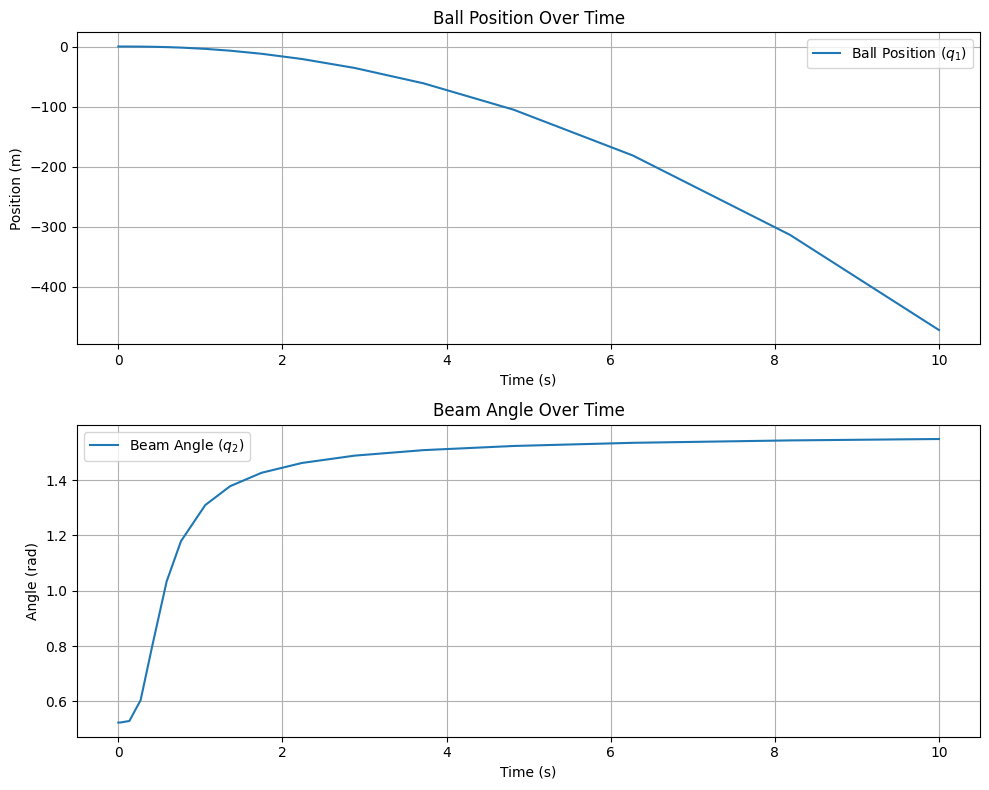

In [177]:
from matplotlib import pyplot as plt

# Extract the solution
t = solution.t
q1, q2, q1_dot, q2_dot = solution.y

# Create the plot
plt.figure(figsize=(10, 8))

# Plot q1, which is the ball position on the beam
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot
plt.plot(t, q1, label='Ball Position ($q_1$)')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Ball Position Over Time')
plt.legend()
plt.grid(True)

# Plot q2, which is the angle of the beam
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd subplot
plt.plot(t, q2, label='Beam Angle ($q_2$)')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.title('Beam Angle Over Time')
plt.legend()
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [178]:
t = me.dynamicsymbols._t # Declare time, because I can be a time lord in Python
q1, q2= me.dynamicsymbols('q1 q2') # q1 = x, q2  = theta
# Define the control law as a torque
Torque = 200*(q1 - q2) + 70*(q1.diff(t) - q2.diff(t))

# Now we include this torque in the Lagrange's equations by adding it as a generalized force
LM = me.LagrangesMethod(L, [q1, q2], forcelist=[(B, Torque * A.z)], frame=A)

# New eq with control law
lagrange_eqs_with_torque = LM.form_lagranges_equations()

lagrange_eqs_with_torque_simplified = sm.trigsimp(lagrange_eqs_with_torque)
lagrange_eqs_with_torque_simplified


Matrix([
[                                                                                                                                                          1.0*m*(g*sin(q2(t)) - q1(t)*Derivative(q2(t), t)**2 + Derivative(q1(t), (t, 2)))],
[1.0*I_beam*Derivative(q2(t), (t, 2)) + g*m*q1(t)*cos(q2(t)) + 1.0*m*q1(t)**2*Derivative(q2(t), (t, 2)) + 2.0*m*q1(t)*Derivative(q1(t), t)*Derivative(q2(t), t) - 200*q1(t) + 200*q2(t) - 70*Derivative(q1(t), t) + 70*Derivative(q2(t), t)]])

In [179]:
lagrange_eqs_with_torque_w_constants = lagrange_eqs_with_torque_simplified.subs({m: m_value, I_beam: I_beam_value, g: g_value})
t_span = (0, 15)  # 15 seconds

# Solving for diff of q1 and q2
second_derivs = sm.solve(lagrange_eqs_with_torque_w_constants, q1.diff(t, 2), q2.diff(t, 2), dict=True)[0]

# Lambdify
q1_ddot_func = sm.lambdify((q1, q2, q1.diff(t), q2.diff(t)), second_derivs[q1.diff(t, 2)])
q2_ddot_func = sm.lambdify((q1, q2, q1.diff(t), q2.diff(t)), second_derivs[q2.diff(t, 2)])

def state_derivatives(t, y):
    q1, q2, q1_dot, q2_dot = y
    
    q1_ddot = q1_ddot_func(q1, q2, q1_dot, q2_dot)
    q2_ddot = q2_ddot_func(q1, q2, q1_dot, q2_dot)
    return [q1_dot, q2_dot, q1_ddot, q2_ddot]

solution_control = solve_ivp(state_derivatives, t_span, initial_conditions, method='RK45', dense_output=True)

solution_control.message


'The solver successfully reached the end of the integration interval.'

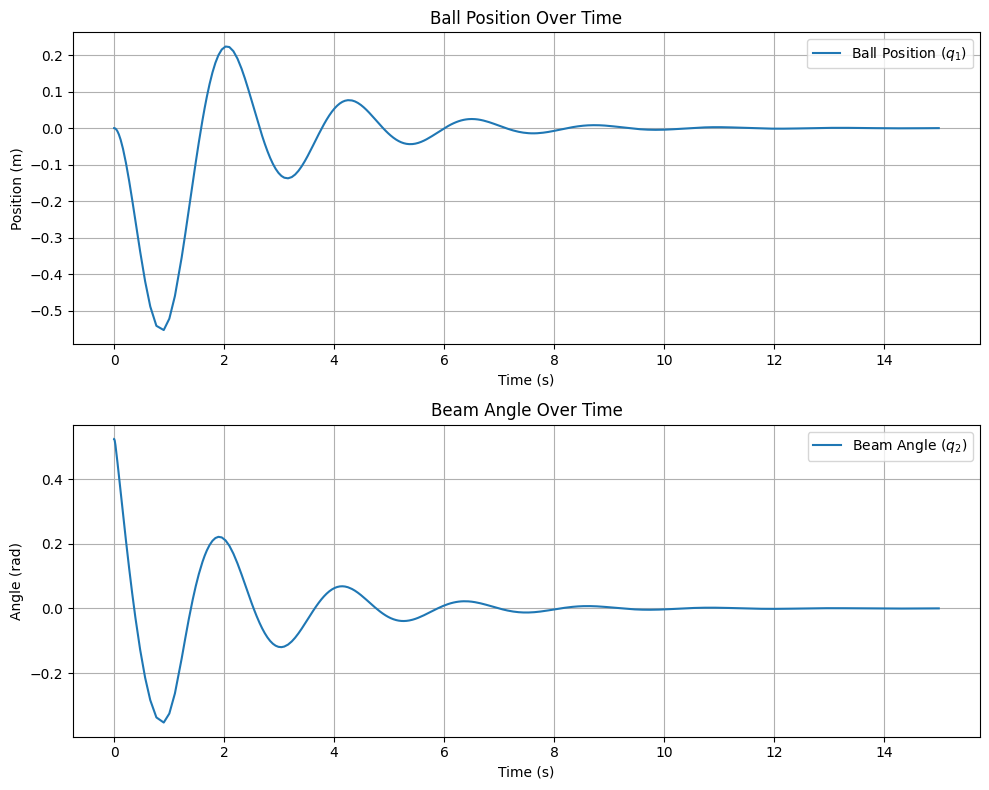

In [180]:
from matplotlib import pyplot as plt

from matplotlib import pyplot as plt

# Extract the solution
t = solution_control.t
q1, q2, q1_dot, q2_dot = solution_control.y

# Create the plot
plt.figure(figsize=(10, 8))

# Plot q1, which is the ball position on the beam
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot
plt.plot(t, q1, label='Ball Position ($q_1$)')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Ball Position Over Time')
plt.legend()
plt.grid(True)

# Plot q2, which is the angle of the beam
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd subplot
plt.plot(t, q2, label='Beam Angle ($q_2$)')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.title('Beam Angle Over Time')
plt.legend()
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

Oscillating a bit here, but stabilizes eventually.

## Disclaimer
<img src="media/ihatematlab.jpg" height="300">


SOoooooo much ChatGPT was used in debugging this exercise in python. Especially the numerical solvers and the graphing of the results. I honestly don't know why I'm doing this to myself anymore. The only thing fueling my motivation is my pure hatred towards Matlab 🤣.